# Project 1

In [1]:
import sys
sys.path.insert(1, '../../../git-projects/scripts/Numerical-Methods/')
sys.path.insert(1, '../../../git-projects/scripts/Orbital-Dynamics/')
from orbital_dynamics import three_body_cr_thrust_propagator

sys.path.insert(1, '../../../git-projects/scripts/Utilities/')
from animations import constant_time_transform

In [2]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

from matplotlib import animation
from matplotlib.animation import PillowWriter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Question 1

## Part 2

In [3]:
# part 2
station_distance = 100
time = (71 * 60 + 12) - (70 * 60 + 3)

soyuz_vel = station_distance / time

lagrange_points_distance = 2 * (384400 * np.sin(np.pi / 3))
travel_time_lagrange = lagrange_points_distance / soyuz_vel

print(f'Soyuz capsule velocity: {round(soyuz_vel, 3)} km/s')
print(f'Time from L5 to L4 at {round(soyuz_vel, 3)} km/s: {round(travel_time_lagrange / (60 * 60 * 24), 3)} days') 

Soyuz capsule velocity: 1.449 km/s
Time from L5 to L4 at 1.449 km/s: 5.317 days


## Part 3

In [4]:
# initial conditions, at L5, v_y = 1.449 km/s
# assuming mass of person + space suit + life support ~ 200 kg
t_0 = 0
t_f = travel_time_lagrange
m = 200

x_0 = 384400 * np.cos(np.pi / 3)
y_0 = -384400 * np.sin(np.pi / 3)
z_0 = 0

vx_0 = 0
vy_0 = soyuz_vel
vz_0 = 0

s_0 = [x_0, y_0, z_0, vx_0, vy_0, vz_0]

In [5]:
# defining thrust function
def l45_constant_vel_thrust(t, x, y, z, v_x, v_y, v_z, m_satellite, omega, r_1, r_2, r_12, mu_1, mu_2, pi_1, pi_2):
    thrust_x = -m_satellite*(2 * omega * v_y + x * omega ** 2 - (mu_1 / r_1 ** 3) * (x + pi_2 * r_12) - (mu_2 / r_2 ** 3) * (x - pi_1 * r_12))
    thrust_y = -m_satellite*(-2 * omega * v_x + y * omega ** 2 - (mu_1 / r_1 ** 3) * y - (mu_2 / r_2 ** 3) * y)
    thrust_z = 0

    return thrust_x, thrust_y, thrust_z

In [6]:
s_out, t_out, thrust_out = three_body_cr_thrust_propagator(t_0, 
                                                           t_f, 
                                                           s_0, 
                                                           l45_constant_vel_thrust, 
                                                           m, 
                                                           grav_constant=6.6742e-20, 
                                                           tolerance=50, 
                                                           return_thrust=True)

len(t_out)

1471

In [7]:
x_out = s_out.T[0]
y_out = s_out.T[1]

vx_out = s_out.T[3]
vy_out = s_out.T[4]

thrust_x_vec = thrust_out[0]
thrust_y_vec = thrust_out[1]
thrust_z_vec = thrust_out[2]

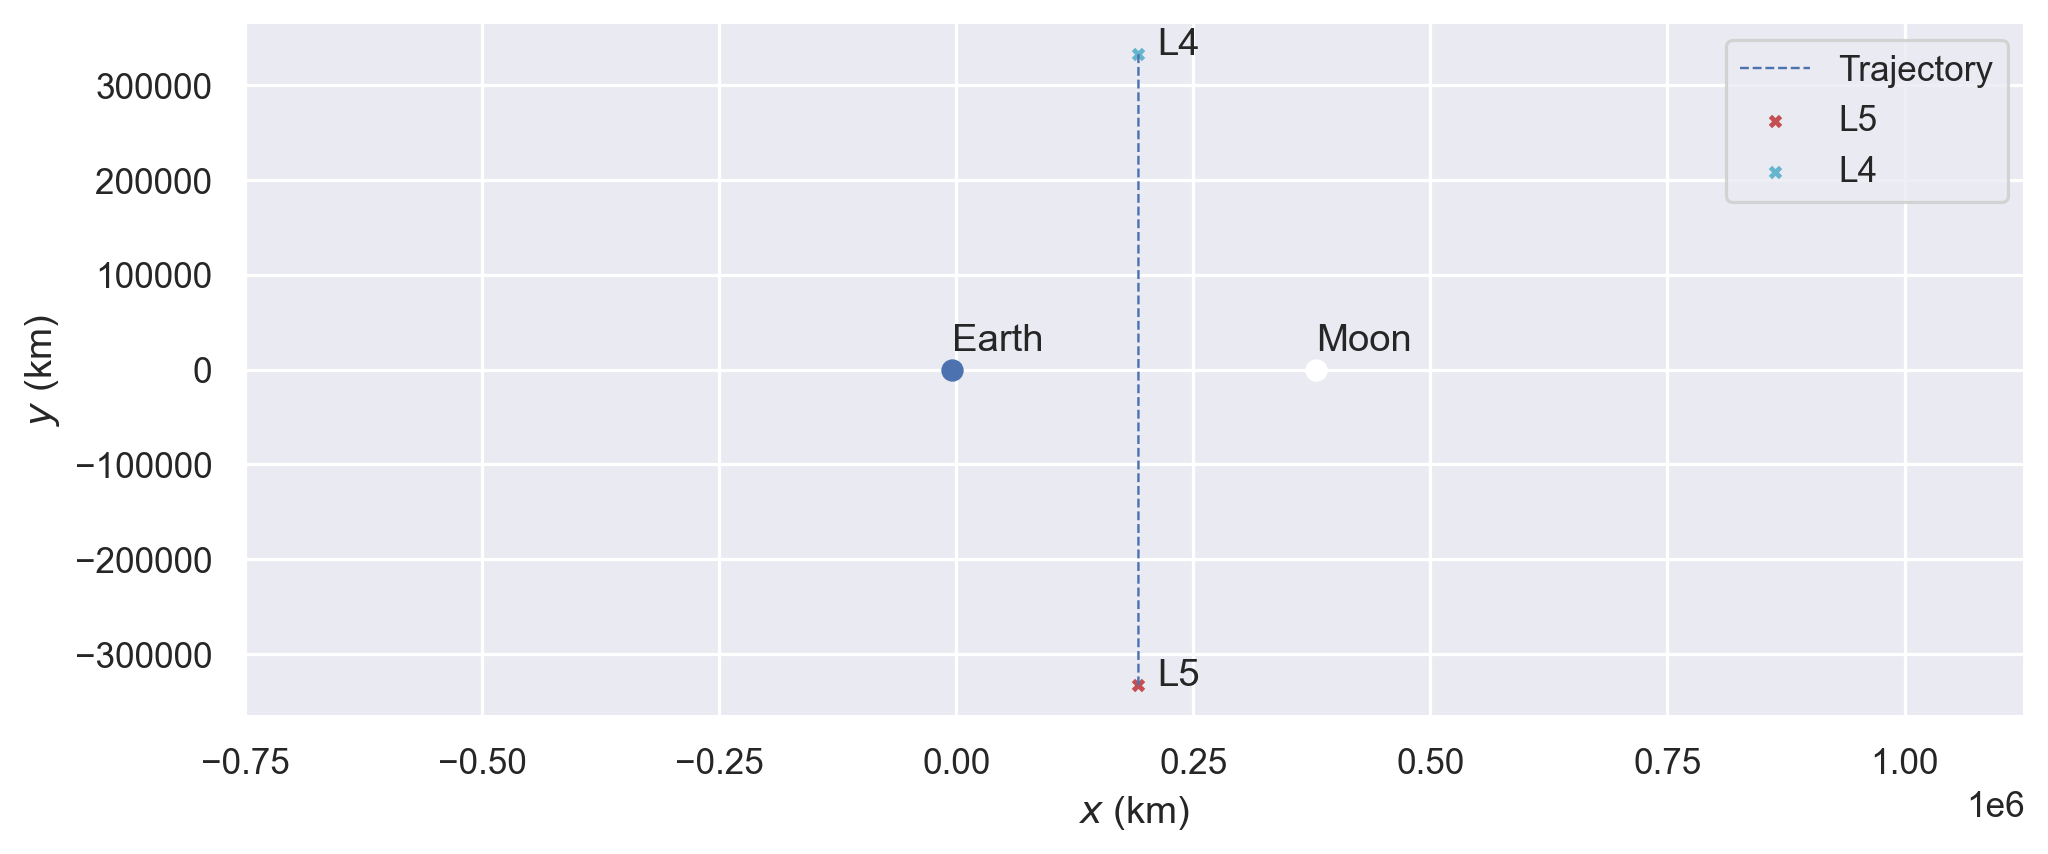

In [8]:
plt.figure(figsize=(10,4), dpi=230)

plt.plot(x_out, y_out, linewidth=0.75, linestyle='--', label='Trajectory')

plt.scatter(384400 * np.cos(np.pi / 3), -384400 * np.sin(np.pi / 3), label='L5', s=10, marker='x', c='r')
plt.annotate('L5', (384400 * np.cos(np.pi / 3) + 20000, -384400 * np.sin(np.pi / 3)))

plt.scatter(384400 * np.cos(np.pi / 3), 384400 * np.sin(np.pi / 3), label='L4', s=10, marker='x', c='c')
plt.annotate('L4', (384400 * np.cos(np.pi / 3) + 20000, 384400 * np.sin(np.pi / 3)))

plt.scatter(-4671, 0, c='b')
plt.annotate('Earth', (-4671, 20000))

plt.scatter(-4671 + 384400, 0, c='w')
plt.annotate('Moon', (-4671 + 384400, 20000))

#plt.title('L5 to L4 Straight-Line Transfer')
plt.xlabel(r'$x$ (km)')
plt.ylabel(r'$y$ (km)')

plt.axis('equal')

plt.legend()

plt.show()

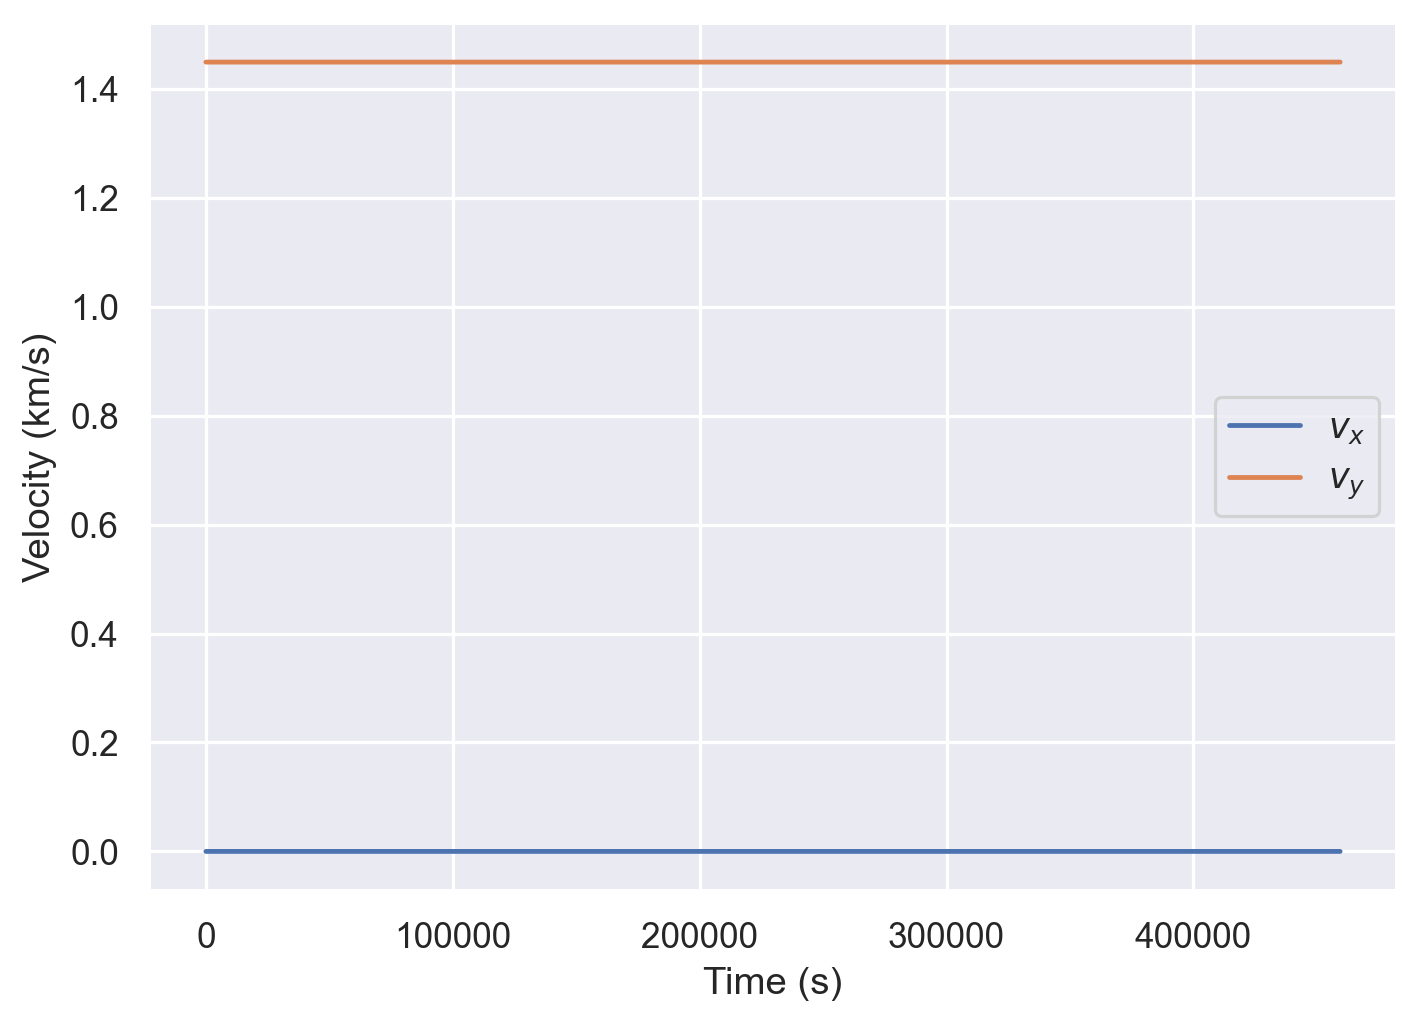

In [9]:
plt.figure(figsize=(7,5), dpi=230)

plt.plot(t_out, vx_out, label=r'$v_x$')
plt.plot(t_out, vy_out, label=r'$v_y$')

plt.xlabel('Time (s)')
plt.ylabel('Velocity (km/s)')

plt.legend()
plt.show()

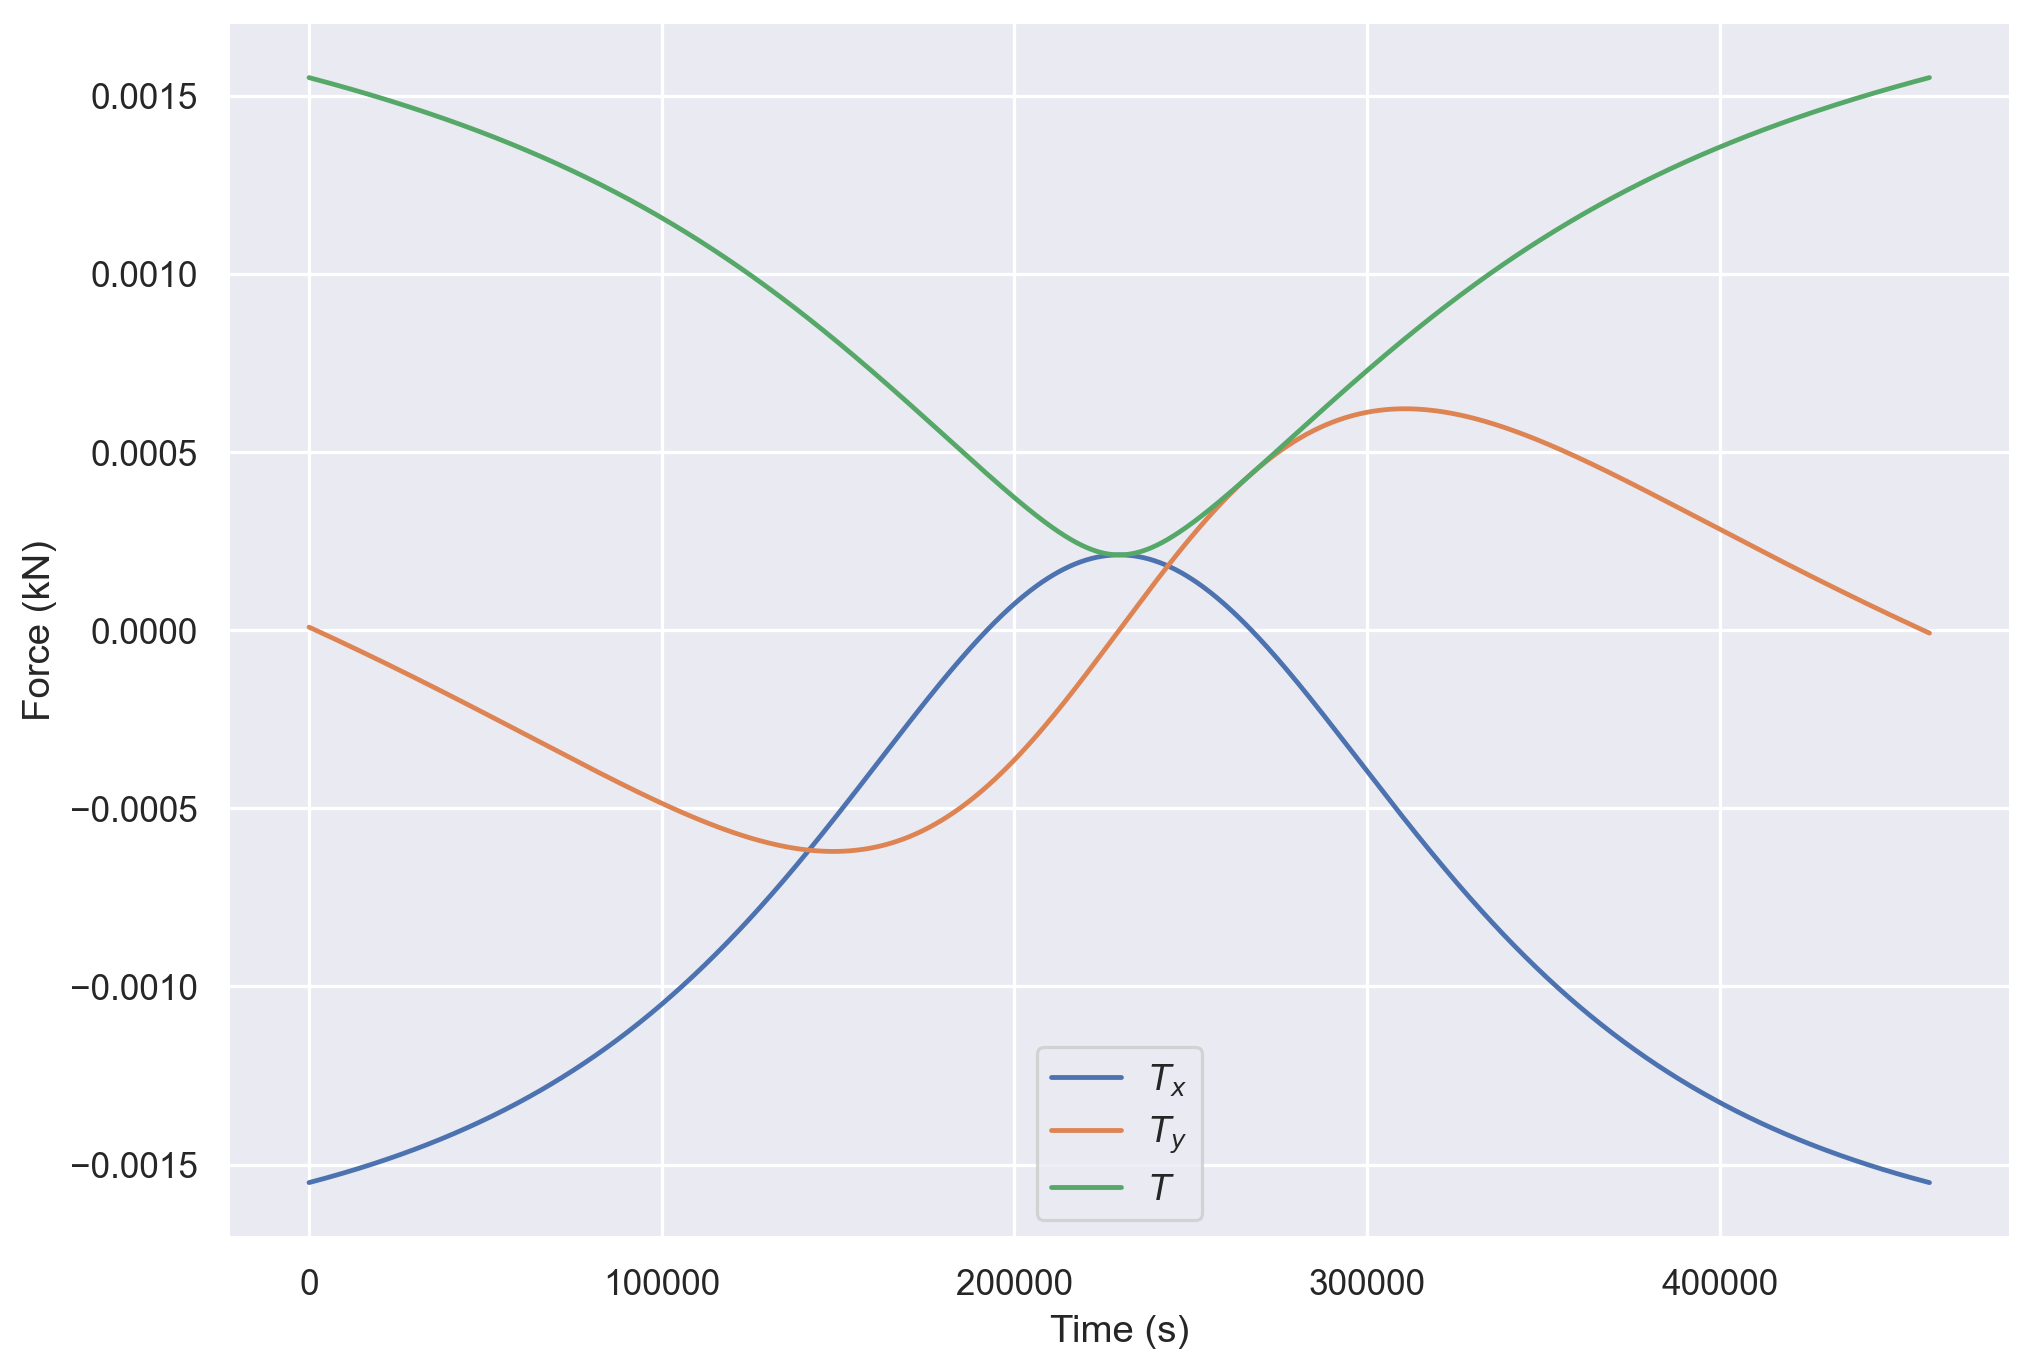

In [10]:
total_thrust = np.sqrt(np.power(thrust_out[0], 2) + np.power(thrust_out[1], 2))

plt.figure(figsize=(10,7), dpi=230)

plt.plot(t_out, thrust_x_vec, label=r'$T_x$')
plt.plot(t_out, thrust_y_vec, label=r'$T_y$')
plt.plot(t_out, total_thrust, label=r'$T$')

plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
#plt.title('Spacecraft Thrust over L5-L4 Transit')

plt.legend()
plt.show()

### Animations

## Part 4

In [11]:
#total_thrust = np.sqrt(np.power(thrust_out[0], 2) + np.power(thrust_out[1], 2))

total_thrust_interp = interp1d(t_out, total_thrust)
total_impulse = quad(total_thrust_interp, 0, travel_time_lagrange)

print(f'Total impulse: {round(total_impulse[0], 1)} kN s +/- {total_thrust[1]}')

Total impulse: 450.4 kN s +/- 0.0015479783200787998


C:\Users\mjski\AppData\Local\Temp/ipykernel_73200/77694765.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  total_impulse = quad(total_thrust_interp, 0, travel_time_lagrange)


In [12]:
total_thrust = np.sqrt(np.power(thrust_out[0], 2) + np.power(thrust_out[1], 2))

total_impulse = sum(total_thrust[:-1] * np.diff(t_out))

total_impulse

450.40686225308576

# Question 2
## Part 5

In [13]:
# lagging satellite to catch up to leading satellite
# original orbit parameters

mu = 398600
r_circ = 384400
phase = np.radians(120)

v_circ = np.sqrt(mu / r_circ)
h_orig = r_circ * v_circ

period_orig = np.power(r_circ, 3/2) * 2*np.pi / np.sqrt(mu)

v_circ, h_orig, period_orig

(1.0183028463009418, 391435.61411808204, 2371844.9190763095)

In [14]:
# find time required to reach B from A
t_AB = period_orig * (phase / (2*np.pi))
t_AB

790614.9730254365

In [15]:
period_phase = period_orig - t_AB

period_phase

1581229.946050873

In [16]:
a_phase = np.power(np.sqrt(mu) * period_phase / (2*np.pi), 2/3)
r_per_phase = 2*a_phase - r_circ

h_phase = np.sqrt(2*mu) * np.sqrt(r_circ * r_per_phase / (r_circ + r_per_phase))

a_phase, r_per_phase, h_phase

(293352.1032250003, 202304.20645000064, 325063.48719530716)

In [17]:
# velocities at beginning of phasing maneuver
v_apo_phase = h_phase / r_circ

delta_A = v_circ - v_apo_phase

total_delta = 2*delta_A

v_apo_phase, delta_A, total_delta

(0.8456386243374275, 0.17266422196351427, 0.34532844392702855)

In [18]:
total_impulse_hohmann = m * total_delta
total_impulse_hohmann

69.06568878540571

In [19]:
difference_impulse = 100*((total_impulse - total_impulse_hohmann)/total_impulse_hohmann)
difference_time = 100*((period_phase - travel_time_lagrange)/travel_time_lagrange)

difference_impulse, difference_time

(552.1427211890217, 244.19292064545127)